In [1]:
from sklearn.model_selection import cross_val_score, GroupKFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Lasso
import lightgbm as lgb
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV
import shap
import pickle
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.colors as mcolors
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt



In [2]:
black = '#515265'
red = '#DD706E'
yellow = '#FAAF3A'
blue = '#3A93C2'

In [3]:
file_path = "../../Exp_2_Dataset_feature_engineering/Summary_and_dataset/PCA_dataset.csv"

data = pd.read_csv(file_path)
train = data[data['Type'] == 'Train']
test = data[data['Type'] == 'Test']
lab = data[data['Type'] == 'Lab']

In [4]:
overlapping_values = set(train['Drug-solvent system']).intersection(test['Drug-solvent system'])
overlapping_values

set()

In [5]:
def data_processing (dataset):

    X = dataset.drop(['Type', 'Drug', 'Solvent_1', 'Solvent_2', 'Drug-solvent system', 'LogS', 'Class', 'Solubility (g/100g)'], axis = 1)
    Y = dataset['LogS']
    G = dataset['Drug-solvent system']

    return X, Y, G

In [6]:
X_train, Y_train, G_train = data_processing(train)
X_test, Y_test, G_test = data_processing(test)
X_lab, Y_lab, G_lab = data_processing(lab)

In [7]:
X_train.shape

(21949, 86)

# Hyperparameter screening

In [8]:
search_spaces = {
    "DT": {
        "max_depth": Integer(3, 20),
        "splitter":Categorical(['best', 'random']),
        "min_samples_split": Real(0.01, 0.1),
        "min_samples_leaf": Integer(1, 20),
        "max_features": Categorical(['auto', 'sqrt', 'log2']),
    },
    "RF": {
        "n_estimators": Integer(10, 400),
        "max_depth": Integer(3, 20),
        "min_samples_split": Real(0.01, 0.1),
        "min_samples_leaf": Integer(1, 20),
        "max_features": Categorical(['auto', 'sqrt', 'log2']),
        "bootstrap": Categorical([True, False]),
    },
    "XGB": {
        "n_estimators": Integer(10, 400),
        "learning_rate": Real(0.01, 0.3, prior="log-uniform"),
        "max_depth": Integer(3, 20),
        "subsample": Real(0.5, 1.0),
        "colsample_bytree": Real(0.5, 1.0),
        "gamma": Real(0, 5),
    },
    "NN": {
        "hidden_layer_sizes": Integer(2, 64),
        "alpha": Real(0.0001, 0.1, prior="log-uniform"),
        "learning_rate_init": Real(0.001, 0.1, prior="log-uniform"),
        "activation": Categorical(['relu', 'tanh', 'logistic']),
},

    "LightGBM": {
        "num_leaves": Integer(10, 400),
        "max_depth": Integer(3, 20),
        "learning_rate": Real(0.01, 0.3, prior="log-uniform"),
        "n_estimators": Integer(100, 1000),
        "bagging_fraction": Real(0.5, 1),
        "feature_fraction": Real(0.5, 1),
        "min_child_samples": Integer(5, 100),
    },
    "MLR": {
        'fit_intercept':Categorical([True, False]),
        'positive':Categorical([True, False])
    },
    "Lasso": {
        "alpha": Real(0.0001, 1, prior="log-uniform"),
        "selection": Categorical(['cyclic', 'random']),
    },
    "kNN": {'n_neighbors':Integer(2, 50),
            'weights': Categorical(["uniform", 'distance']),
            'algorithm': Categorical(['auto', 'ball_tree', 'kd_tree', 'brute']),
            'leaf_size': Integer(10, 100),
            'p':Integer(1, 2),
    },
    "PLS": {'n_components':Integer(2, 6),
            'max_iter': Integer(250, 1000)
    }
    
}


In [9]:
models = {
    "DT": DecisionTreeRegressor(random_state=0),
    "RF": RandomForestRegressor(random_state=0, n_jobs=6),
    "XGB": XGBRegressor(random_state=0, n_jobs=6),
    "NN": MLPRegressor(random_state=0),
    "LightGBM": lgb.LGBMRegressor(random_state=0, n_jobs=6),
    "MLR": LinearRegression(),
    "Lasso": Lasso(),
    "PLS": PLSRegression(),
    "kNN": KNeighborsRegressor(n_jobs=6)}

In [10]:
def perform_hp_screening(model_name, X_train, Y_train, G_train, n_iter):

    
    model = models[model_name]
    search_space = search_spaces[model_name]
    
    cv = GroupKFold(n_splits=10)

    
    bscv = BayesSearchCV(
        estimator=model,
        search_spaces=search_space,
        scoring='neg_mean_absolute_error',
        cv=cv,
        n_iter=n_iter,
        n_jobs=6,
        verbose=0,
        random_state = 0
    )

    
    bscv.fit(X_train, Y_train, groups=G_train)

    
    return bscv.best_estimator_, bscv.best_params_, bscv.best_score_


In [11]:
model_names = ["DT", "RF", "XGB",  "NN", "LightGBM", "MLR", "Lasso", "PLS", "kNN"]
results = {}

n_iter = 100


In [23]:
for model_name in model_names:
    
    
    search_space = search_spaces[model_name]
    best_model, best_params, best_score = perform_hp_screening(model_name, X_train, Y_train, G_train, n_iter)
    
    
    print(model_name, ':  ', round(best_score,3))
    
    # Storing the results in a dictionary
    results[model_name] = {
        'best_estimator': best_model,
        'best_params': best_params,
        'best_score': best_score
    }

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: Fu

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: Fu

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

DT :   -0.757


/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will b

RF :   -0.624


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


XGB :   -0.524
NN :   -0.416
[LightGBM] [Warning] feature_fraction is set=0.8380397544384568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380397544384568
[LightGBM] [Warning] bagging_fraction is set=0.7654820824760737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654820824760737
[LightGBM] [Warning] feature_fraction is set=0.8380397544384568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380397544384568
[LightGBM] [Warning] bagging_fraction is set=0.7654820824760737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654820824760737
[LightGBM] [Warning] feature_fraction is set=0.9894518292131809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9894518292131809
[LightGBM] [Warning] bagging_fraction is set=0.629185830986374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.629185830986374
[LightGBM] [Warning] feature_fraction is set=0.9894518292131809, colsa

[LightGBM] [Warning] feature_fraction is set=0.8380397544384568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380397544384568
[LightGBM] [Warning] bagging_fraction is set=0.7654820824760737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654820824760737
[LightGBM] [Warning] feature_fraction is set=0.8380397544384568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380397544384568
[LightGBM] [Warning] bagging_fraction is set=0.7654820824760737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654820824760737
[LightGBM] [Warning] feature_fraction is set=0.9894518292131809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9894518292131809
[LightGBM] [Warning] bagging_fraction is set=0.629185830986374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.629185830986374
[LightGBM] [Warning] feature_fraction is set=0.9894518292131809, colsample_bytree=1.0 will be ignor

[LightGBM] [Warning] feature_fraction is set=0.8380397544384568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380397544384568
[LightGBM] [Warning] bagging_fraction is set=0.7654820824760737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654820824760737
[LightGBM] [Warning] feature_fraction is set=0.8380397544384568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380397544384568
[LightGBM] [Warning] bagging_fraction is set=0.7654820824760737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654820824760737
[LightGBM] [Warning] feature_fraction is set=0.9894518292131809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9894518292131809
[LightGBM] [Warning] bagging_fraction is set=0.629185830986374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.629185830986374
[LightGBM] [Warning] feature_fraction is set=0.9894518292131809, colsample_bytree=1.0 will be ignor

[LightGBM] [Warning] feature_fraction is set=0.8380397544384568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380397544384568
[LightGBM] [Warning] bagging_fraction is set=0.7654820824760737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654820824760737
[LightGBM] [Warning] feature_fraction is set=0.9894518292131809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9894518292131809
[LightGBM] [Warning] bagging_fraction is set=0.629185830986374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.629185830986374
[LightGBM] [Warning] feature_fraction is set=0.5289489218467651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5289489218467651
[LightGBM] [Warning] bagging_fraction is set=0.7643458710377254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7643458710377254
[LightGBM] [Warning] feature_fraction is set=0.5289489218467651, colsample_bytree=1.0 will be ignor

[LightGBM] [Warning] feature_fraction is set=0.8380397544384568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380397544384568
[LightGBM] [Warning] bagging_fraction is set=0.7654820824760737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654820824760737
[LightGBM] [Warning] feature_fraction is set=0.8380397544384568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380397544384568
[LightGBM] [Warning] bagging_fraction is set=0.7654820824760737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654820824760737
[LightGBM] [Warning] feature_fraction is set=0.9894518292131809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9894518292131809
[LightGBM] [Warning] bagging_fraction is set=0.629185830986374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.629185830986374
[LightGBM] [Warning] feature_fraction is set=0.5289489218467651, colsample_bytree=1.0 will be ignor

[LightGBM] [Warning] feature_fraction is set=0.8380397544384568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380397544384568
[LightGBM] [Warning] bagging_fraction is set=0.7654820824760737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654820824760737
[LightGBM] [Warning] feature_fraction is set=0.9894518292131809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9894518292131809
[LightGBM] [Warning] bagging_fraction is set=0.629185830986374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.629185830986374
[LightGBM] [Warning] feature_fraction is set=0.9894518292131809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9894518292131809
[LightGBM] [Warning] bagging_fraction is set=0.629185830986374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.629185830986374
[LightGBM] [Warning] feature_fraction is set=0.5289489218467651, colsample_bytree=1.0 will be ignored

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8628039089299073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8628039089299073
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[Light

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.59814760126243, subsample=1.0 will be ignored. Current value: bagging_fraction=0.59814760126243
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.59814760126243, subsample=1.0 will be ignored. Current value: bagging_fraction=0.59814760126243
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: baggi

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fractio

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7390257893004146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7390257893004146
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7390257893004146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7390257893004146
[LightGBM] [Warning] feature_fraction is set=0.503125905880652, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.503125905880652
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 wi

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
LightGBM :   -0.509


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The object

MLR :   -0.593
Lasso :   -0.545


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The object

PLS :   -0.545


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


kNN :   -0.458


In [12]:
pickle_file_path = 'Results/PCA_BSCV_results.pkl'

In [25]:

with open(pickle_file_path, 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:

with open(pickle_file_path, 'rb') as handle:
    results = pickle.load(handle)

Trying to unpickle estimator DecisionTreeRegressor from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator RandomForestRegressor from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator MLPRegressor from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator LinearRegression from version 1.1.3 when using version 1.1.2. This might lead to breaking code or 

In [14]:
results

{'DT': {'best_estimator': DecisionTreeRegressor(max_depth=20, max_features='log2', min_samples_leaf=20,
                        min_samples_split=0.060570887167090026, random_state=0,
                        splitter='random'),
  'best_params': OrderedDict([('max_depth', 20),
               ('max_features', 'log2'),
               ('min_samples_leaf', 20),
               ('min_samples_split', 0.060570887167090026),
               ('splitter', 'random')]),
  'best_score': -0.7571528124606766},
 'RF': {'best_estimator': RandomForestRegressor(bootstrap=False, max_depth=17, max_features='sqrt',
                        min_samples_leaf=15, min_samples_split=0.01,
                        n_estimators=400, n_jobs=6, random_state=0),
  'best_params': OrderedDict([('bootstrap', False),
               ('max_depth', 17),
               ('max_features', 'sqrt'),
               ('min_samples_leaf', 15),
               ('min_samples_split', 0.01),
               ('n_estimators', 400)]),
  'best_scor

# Model evaluation using the literature test set

In [15]:

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


metrics = ['MAE', 'MedAE', 'RMSE', 'MSE']
train_summary = pd.DataFrame(index=metrics, columns=model_names)
test_summary = pd.DataFrame(index=metrics, columns=model_names)
predictions = pd.DataFrame(columns=model_names)


for model_name in model_names:
    model = results[model_name]['best_estimator']

    
    cv = GroupKFold(n_splits=10)
    Y_pred_train = cross_val_predict(model, X_train, Y_train, cv=cv, groups=G_train, n_jobs=6)
    
    train_summary[model_name]['MAE'] = mean_absolute_error(Y_train, Y_pred_train)
    train_summary[model_name]['MedAE'] = np.median(abs(Y_train.values - Y_pred_train))
    train_summary[model_name]['RMSE'] = rmse(Y_train, Y_pred_train)
    train_summary[model_name]['MSE'] = mean_squared_error(Y_train, Y_pred_train)


    
    model.fit(X_train, Y_train)
    Y_pred_test = model.predict(X_test)
    
    test_summary[model_name]['MAE'] = mean_absolute_error(Y_test, Y_pred_test)
    test_summary[model_name]['MedAE'] = np.median(abs(Y_test.values - Y_pred_test))
    test_summary[model_name]['RMSE'] = rmse(Y_test, Y_pred_test)
    test_summary[model_name]['MSE'] = mean_squared_error(Y_test, Y_pred_test)
    
    predictions[model_name] = Y_pred_test


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


In [16]:
train_summary

,DT,RF,XGB,NN,LightGBM,MLR,Lasso,PLS,kNN
MAE,0.757186,0.6238,0.523776,0.4315,0.50949,0.593399,0.544851,0.544613,0.458467
MedAE,0.626584,0.545292,0.41694,0.313768,0.404213,0.425768,0.438597,0.896023,0.281916
RMSE,0.966386,0.777509,0.682287,0.602138,0.661745,0.893946,0.706425,0.710958,0.713309
MSE,0.933902,0.60452,0.465515,0.362571,0.437907,0.799139,0.499037,0.505461,0.508809


In [17]:
test_summary

,DT,RF,XGB,NN,LightGBM,MLR,Lasso,PLS,kNN
MAE,0.780118,0.598789,0.513953,0.306239,0.464754,0.503259,0.524709,0.503259,0.357962
MedAE,0.625667,0.504767,0.428661,0.232323,0.394199,0.432773,0.442599,0.935527,0.190224
RMSE,1.00552,0.760625,0.66834,0.421689,0.5895,0.642281,0.661254,0.642281,0.572227
MSE,1.011071,0.57855,0.446678,0.177822,0.34751,0.412525,0.437257,0.412525,0.327443


In [18]:
test_AE = predictions.copy()

test_AE['Y'] = Y_test.values

for model_name in model_names:
    test_AE[model_name] = abs(test_AE[model_name] - test_AE['Y'])
    
test_AE = test_AE.drop(['Y'], axis = 1)    
test_AE

,DT,RF,XGB,NN,LightGBM,MLR,Lasso,PLS,kNN
0,0.551484,0.212769,0.130179,0.253960,0.145856,0.074110,0.063700,0.074110,0.075138
1,2.225020,1.784366,1.057187,0.133246,1.094864,1.123058,1.231318,1.123058,1.275447
2,2.117399,1.669603,0.933867,0.097010,0.986695,1.083763,1.175568,1.083763,1.196579
3,2.014196,1.572817,0.824859,0.065191,0.876369,1.048885,1.124235,1.048885,1.122783
4,1.910675,1.485969,0.745252,0.033056,0.855336,1.013691,1.072585,1.013691,1.050462
...,...,...,...,...,...,...,...,...,...
5303,0.132549,0.407921,0.358214,0.176791,0.456281,0.048261,0.118145,0.048261,0.310451
5304,0.413847,0.128513,0.047522,0.224043,0.130664,0.156505,0.168897,0.156505,0.294139
5305,0.517198,0.219186,0.119209,0.235899,0.157897,0.191530,0.220377,0.191530,0.299238
5306,0.613152,0.292396,0.160020,0.233214,0.136244,0.219158,0.264460,0.219158,0.298914


In [19]:
for column in train_summary.columns:
    train_summary[column] = train_summary[column].astype(float)
    test_summary[column] = test_summary[column].astype(float)

In [20]:
train_summary_round = train_summary.round(3)
test_summary_round = test_summary.round(3)

In [21]:
train_summary_round

,DT,RF,XGB,NN,LightGBM,MLR,Lasso,PLS,kNN
MAE,0.757,0.624,0.524,0.431,0.509,0.593,0.545,0.545,0.458
MedAE,0.627,0.545,0.417,0.314,0.404,0.426,0.439,0.896,0.282
RMSE,0.966,0.778,0.682,0.602,0.662,0.894,0.706,0.711,0.713
MSE,0.934,0.605,0.466,0.363,0.438,0.799,0.499,0.505,0.509


In [22]:
test_summary_round

,DT,RF,XGB,NN,LightGBM,MLR,Lasso,PLS,kNN
MAE,0.780,0.599,0.514,0.306,0.465,0.503,0.525,0.503,0.358
MedAE,0.626,0.505,0.429,0.232,0.394,0.433,0.443,0.936,0.190
RMSE,1.006,0.761,0.668,0.422,0.589,0.642,0.661,0.642,0.572
MSE,1.011,0.579,0.447,0.178,0.348,0.413,0.437,0.413,0.327


In [23]:
test_summary_round_T = test_summary_round.T
test_summary_round_T

,MAE,MedAE,RMSE,MSE
DT,0.780,0.626,1.006,1.011
RF,0.599,0.505,0.761,0.579
XGB,0.514,0.429,0.668,0.447
NN,0.306,0.232,0.422,0.178
LightGBM,0.465,0.394,0.589,0.348
MLR,0.503,0.433,0.642,0.413
Lasso,0.525,0.443,0.661,0.437
PLS,0.503,0.936,0.642,0.413
kNN,0.358,0.190,0.572,0.327


In [24]:
sorted_models_ind = test_summary_round_T.sort_values(by="MAE", ascending=True).index
sorted_models = test_summary_round_T.loc[sorted_models_ind]
sorted_models



,MAE,MedAE,RMSE,MSE
NN,0.306,0.232,0.422,0.178
kNN,0.358,0.190,0.572,0.327
LightGBM,0.465,0.394,0.589,0.348
MLR,0.503,0.433,0.642,0.413
PLS,0.503,0.936,0.642,0.413
XGB,0.514,0.429,0.668,0.447
Lasso,0.525,0.443,0.661,0.437
RF,0.599,0.505,0.761,0.579
DT,0.780,0.626,1.006,1.011


In [25]:
test_AE = test_AE[sorted_models_ind]
test_AE

,NN,kNN,LightGBM,MLR,PLS,XGB,Lasso,RF,DT
0,0.253960,0.075138,0.145856,0.074110,0.074110,0.130179,0.063700,0.212769,0.551484
1,0.133246,1.275447,1.094864,1.123058,1.123058,1.057187,1.231318,1.784366,2.225020
2,0.097010,1.196579,0.986695,1.083763,1.083763,0.933867,1.175568,1.669603,2.117399
3,0.065191,1.122783,0.876369,1.048885,1.048885,0.824859,1.124235,1.572817,2.014196
4,0.033056,1.050462,0.855336,1.013691,1.013691,0.745252,1.072585,1.485969,1.910675
...,...,...,...,...,...,...,...,...,...
5303,0.176791,0.310451,0.456281,0.048261,0.048261,0.358214,0.118145,0.407921,0.132549
5304,0.224043,0.294139,0.130664,0.156505,0.156505,0.047522,0.168897,0.128513,0.413847
5305,0.235899,0.299238,0.157897,0.191530,0.191530,0.119209,0.220377,0.219186,0.517198
5306,0.233214,0.298914,0.136244,0.219158,0.219158,0.160020,0.264460,0.292396,0.613152


In [26]:
test_summary_round = test_summary_round[sorted_models_ind]
test_summary_round.to_excel('Figure_3b.xlsx', index = True)
test_summary_round

,NN,kNN,LightGBM,MLR,PLS,XGB,Lasso,RF,DT
MAE,0.306,0.358,0.465,0.503,0.503,0.514,0.525,0.599,0.780
MedAE,0.232,0.190,0.394,0.433,0.936,0.429,0.443,0.505,0.626
RMSE,0.422,0.572,0.589,0.642,0.642,0.668,0.661,0.761,1.006
MSE,0.178,0.327,0.348,0.413,0.413,0.447,0.437,0.579,1.011


In [27]:
train_summary_round = train_summary_round[sorted_models_ind]
train_summary_round.to_excel('Figure_SI_training_results.xlsx', index = True)
train_summary_round

,NN,kNN,LightGBM,MLR,PLS,XGB,Lasso,RF,DT
MAE,0.431,0.458,0.509,0.593,0.545,0.524,0.545,0.624,0.757
MedAE,0.314,0.282,0.404,0.426,0.896,0.417,0.439,0.545,0.627
RMSE,0.602,0.713,0.662,0.894,0.711,0.682,0.706,0.778,0.966
MSE,0.363,0.509,0.438,0.799,0.505,0.466,0.499,0.605,0.934


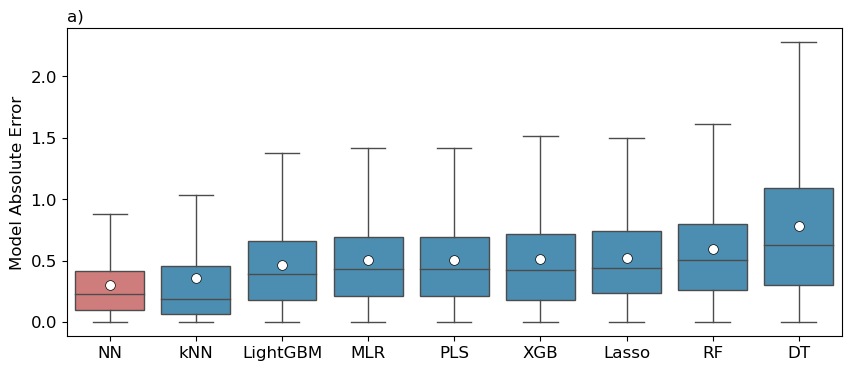

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fractio

In [28]:

plt.figure(figsize=(10, 4))
plt.rcParams.update({'font.size': 12})


palette = [red] + [blue] * (len(test_AE.columns) - 1)


sns.boxplot(data=test_AE, palette=palette, showfliers=False, showmeans=True,linewidth = 1.0, 
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"white", "markersize": 7, "markeredgewidth": 0.5, "markeredgecolor": "black"})


        
plt.title('')
plt.ylabel('Model Absolute Error')

plt.annotate('a)', xy=(0, 1.06), xycoords="axes fraction", va="top", ha="left", fontsize=12)
plt.savefig('Figure_SI_PCA_Model_test_boxplots.png', transparent=True, dpi=300)